# TNT Cates (Living Polymers): SAOS

## Objectives
- Fit TNTCates model to small-amplitude oscillatory shear (SAOS) data
- Show Maxwell-like behavior in fast-breaking limit
- Analyze Cole-Cole plot (semicircular diagnostic for living polymers)
- Extract tau_d from frequency response G'(ω) and G''(ω)
- Perform Bayesian inference with NUTS

## Setup

In [1]:
import os
import sys
import time

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax

import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from rheojax.core.jax_config import safe_import_jax
jax, jnp = safe_import_jax()
from rheojax.core.jax_config import verify_float64
verify_float64()

from rheojax.models.tnt import TNTCates

sys.path.insert(0, os.path.join("..", "utils"))
from tnt_tutorial_utils import (
    load_epstein_saos,
    compute_fit_quality,
    print_convergence_summary,
    print_parameter_comparison,
    save_tnt_results,
    get_tnt_cates_param_names,
    compute_cates_tau_d,
    plot_cates_cole_cole,
    compute_maxwell_moduli,
)

param_names = get_tnt_cates_param_names()
print(f"TNTCates parameters: {param_names}")

TNTCates parameters: ['G_0', 'tau_rep', 'tau_break', 'eta_s']


## Theory: Cates Model for SAOS

The Cates model predicts frequency-dependent moduli for wormlike micelles:

**Storage and loss moduli (fast-breaking limit):**
$$G'(\omega) = G_0 \frac{(\omega \tau_d)^2}{1 + (\omega \tau_d)^2}$$
$$G''(\omega) = G_0 \frac{\omega \tau_d}{1 + (\omega \tau_d)^2}$$

where $\tau_d = \sqrt{\tau_{\text{rep}} \cdot \tau_{\text{break}}}$.

**Cole-Cole plot diagnostic:**
Plot $G''$ vs $G'$ gives a semicircle for single-mode Maxwell behavior:
- Ideal living polymers: Perfect semicircle
- Deviations indicate multimode relaxation or structural complexity

**Crossover frequency:**
At $\omega = 1/\tau_d$: $G' = G'' = G_0/2$ (terminal relaxation)

## Load SAOS Data

Data points: 19
Frequency range: 1.01e-01 to 9.94e+01 rad/s
G' range: 8.28e+00 to 2.93e+03 Pa
G'' range: 2.78e+01 to 2.22e+03 Pa


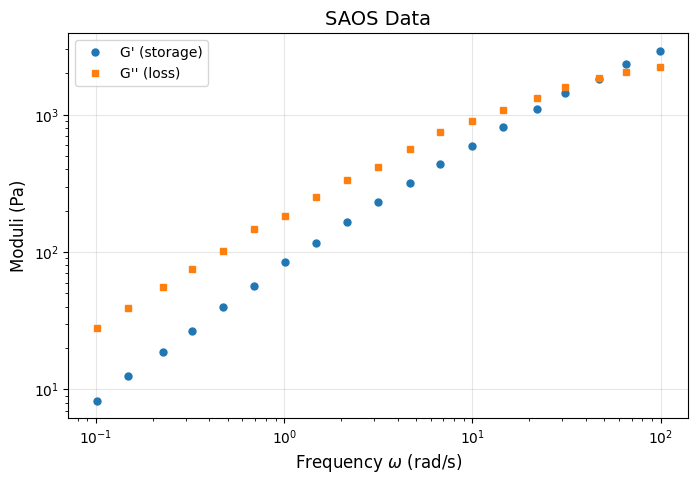

In [2]:
omega, G_prime_data, G_double_prime_data = load_epstein_saos()

G_star_mag = np.sqrt(G_prime_data**2 + G_double_prime_data**2)

print(f"Data points: {len(omega)}")
print(f"Frequency range: {omega.min():.2e} to {omega.max():.2e} rad/s")
print(f"G' range: {G_prime_data.min():.2e} to {G_prime_data.max():.2e} Pa")
print(f"G'' range: {G_double_prime_data.min():.2e} to {G_double_prime_data.max():.2e} Pa")

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(omega, G_prime_data, 'o', label="G' (storage)", markersize=5)
ax.loglog(omega, G_double_prime_data, 's', label="G'' (loss)", markersize=5)
ax.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=12)
ax.set_ylabel('Moduli (Pa)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('SAOS Data', fontsize=14)
plt.show()
plt.close('all')

## NLSQ Fitting

In [3]:
model = TNTCates()

start_time = time.time()
model.fit(omega, G_star_mag, test_mode='oscillation', method='scipy')
fit_time = time.time() - start_time

print(f"\nNLSQ Optimization completed in {fit_time:.2f} seconds")

# Extract fitted parameters
nlsq_params = {name: model.parameters.get_value(name) for name in param_names}
print("\nNLSQ Parameters:")
for name, value in nlsq_params.items():
    print(f"  {name}: {value:.4e}")

# Compute fit quality
G_star_pred_fit = model.predict(omega, test_mode='oscillation')
quality = compute_fit_quality(G_star_mag, G_star_pred_fit)
print(f"\nFit Quality: R² = {quality['R2']:.6f}, RMSE = {quality['RMSE']:.4e}")


NLSQ Optimization completed in 0.65 seconds

NLSQ Parameters:
  G_0: 8.7514e+02
  tau_rep: 4.1905e-01
  tau_break: 9.4596e-02
  eta_s: 4.3921e+01

Fit Quality: R² = 0.953143, RMSE = 2.3937e+02


## Visualize NLSQ Fit

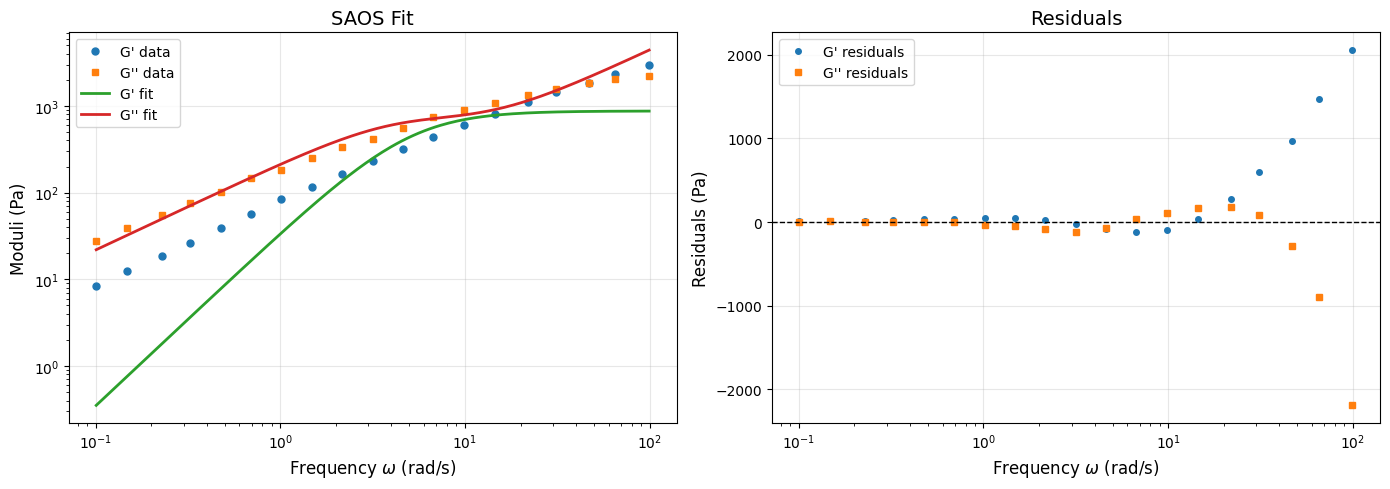

In [4]:
omega_pred = jnp.logspace(jnp.log10(omega.min()), jnp.log10(omega.max()), 200)
G_prime_pred, G_double_prime_pred = model.predict_saos(omega_pred)

# Compute residuals using G* magnitude prediction
G_star_pred_fit = model.predict(omega, test_mode='oscillation')
residuals_Gp = G_prime_data - model.predict_saos(omega)[0]
residuals_Gpp = G_double_prime_data - model.predict_saos(omega)[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.loglog(omega, G_prime_data, 'o', label="G' data", markersize=5)
ax1.loglog(omega, G_double_prime_data, 's', label="G'' data", markersize=5)
ax1.loglog(omega_pred, G_prime_pred, '-', linewidth=2, label="G' fit")
ax1.loglog(omega_pred, G_double_prime_pred, '-', linewidth=2, label="G'' fit")
ax1.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=12)
ax1.set_ylabel('Moduli (Pa)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title('SAOS Fit', fontsize=14)

ax2.semilogx(omega, residuals_Gp, 'o', label="G' residuals", markersize=4)
ax2.semilogx(omega, residuals_Gpp, 's', label="G'' residuals", markersize=4)
ax2.axhline(0, color='k', linestyle='--', linewidth=1)
ax2.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=12)
ax2.set_ylabel('Residuals (Pa)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_title('Residuals', fontsize=14)

plt.tight_layout()
plt.show()
plt.close('all')

## Physical Analysis: Cole-Cole Plot


Physical Analysis:
  Reptation time (tau_rep): 4.1905e-01 s
  Breaking time (tau_break): 9.4596e-02 s
  Effective relaxation time (tau_d): 1.9910e-01 s
  Crossover frequency (ω_c = 1/tau_d): 1.0078e-01 rad/s
  tau_d from crossover: 9.9223e+00 s


  Agreement: 4883.6% difference
  Fast-breaking parameter (zeta): 0.2257

  → Not in fast-breaking limit: May show deviations from Maxwell


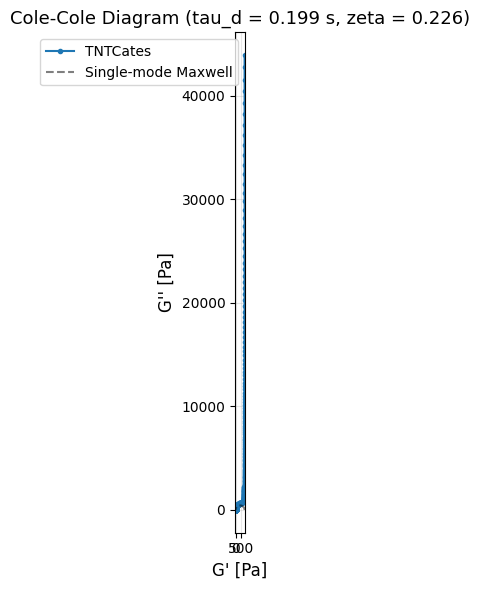

In [5]:
tau_d = compute_cates_tau_d(nlsq_params['tau_rep'], nlsq_params['tau_break'])
zeta = nlsq_params['tau_break'] / nlsq_params['tau_rep']

crossover_idx = jnp.argmin(jnp.abs(G_prime_pred - G_double_prime_pred))
omega_crossover = omega_pred[crossover_idx]
tau_d_from_crossover = 1.0 / omega_crossover

print(f"\nPhysical Analysis:")
print(f"  Reptation time (tau_rep): {nlsq_params['tau_rep']:.4e} s")
print(f"  Breaking time (tau_break): {nlsq_params['tau_break']:.4e} s")
print(f"  Effective relaxation time (tau_d): {tau_d:.4e} s")
print(f"  Crossover frequency (ω_c = 1/tau_d): {omega_crossover:.4e} rad/s")
print(f"  tau_d from crossover: {tau_d_from_crossover:.4e} s")
print(f"  Agreement: {abs(tau_d - tau_d_from_crossover)/tau_d * 100:.1f}% difference")
print(f"  Fast-breaking parameter (zeta): {zeta:.4f}")

if zeta < 0.1:
    print(f"\n  → Fast-breaking limit: Maxwell-like SAOS behavior")
else:
    print(f"\n  → Not in fast-breaking limit: May show deviations from Maxwell")

fig = plot_cates_cole_cole(model)
plt.show()
plt.close('all')

## Compare with Single-Mode Maxwell

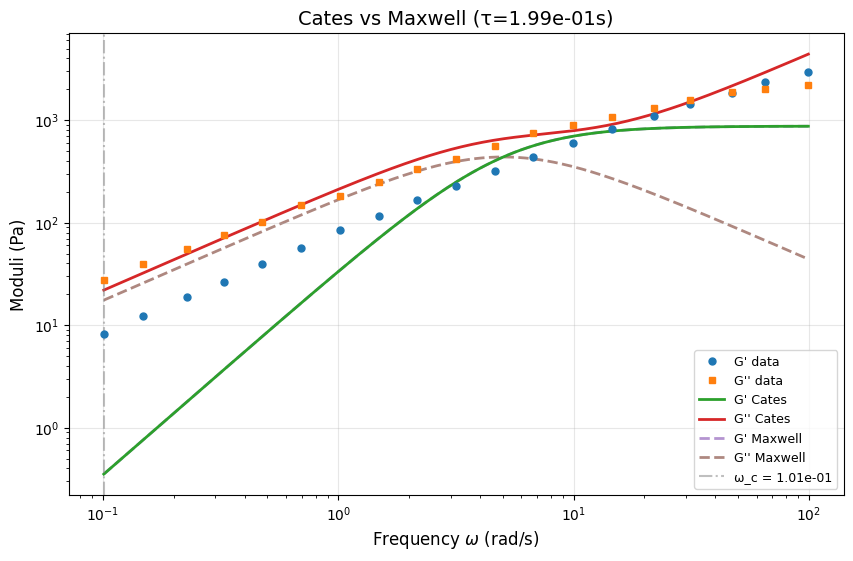

In [6]:
G_prime_maxwell, G_double_prime_maxwell = compute_maxwell_moduli(
    omega_pred, nlsq_params['G_0'], tau_d
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(omega, G_prime_data, 'o', label="G' data", markersize=5, zorder=3)
ax.loglog(omega, G_double_prime_data, 's', label="G'' data", markersize=5, zorder=3)
ax.loglog(omega_pred, G_prime_pred, '-', linewidth=2, label="G' Cates", zorder=2)
ax.loglog(omega_pred, G_double_prime_pred, '-', linewidth=2, label="G'' Cates", zorder=2)
ax.loglog(omega_pred, G_prime_maxwell, '--', linewidth=2, alpha=0.7, label="G' Maxwell", zorder=1)
ax.loglog(omega_pred, G_double_prime_maxwell, '--', linewidth=2, alpha=0.7, label="G'' Maxwell", zorder=1)
ax.axvline(omega_crossover, color='gray', linestyle='-.', alpha=0.5, label=f'ω_c = {omega_crossover:.2e}')
ax.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=12)
ax.set_ylabel('Moduli (Pa)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_title(f'Cates vs Maxwell (τ={tau_d:.2e}s)', fontsize=14)
plt.show()
plt.close('all')

## Bayesian Inference with NUTS

In [7]:
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

print(f"Starting Bayesian inference with NUTS...")
print(f"Warmup: {NUM_WARMUP}, Samples: {NUM_SAMPLES}, Chains: {NUM_CHAINS}")

start_time = time.time()
bayesian_result = model.fit_bayesian(
    omega, G_star_mag,
    test_mode='oscillation',
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    seed=42
)
bayes_time = time.time() - start_time

print(f"\nBayesian inference completed in {bayes_time:.2f} seconds")
print(f"Time per sample: {bayes_time/(NUM_WARMUP + NUM_SAMPLES):.3f} seconds")

Starting Bayesian inference with NUTS...
Warmup: 200, Samples: 500, Chains: 1


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:01<17:38,  1.51s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   2%|▏         | 17/700 [00:01<00:48, 14.10it/s, 511 steps of size 1.74e-03. acc. prob=0.82]

warmup:   4%|▎         | 25/700 [00:01<00:35, 19.25it/s, 63 steps of size 3.74e-03. acc. prob=0.88] 

warmup:   5%|▍         | 33/700 [00:01<00:25, 26.57it/s, 127 steps of size 7.32e-03. acc. prob=0.91]

warmup:   6%|▋         | 45/700 [00:02<00:16, 40.38it/s, 127 steps of size 8.79e-03. acc. prob=0.93]

warmup:  12%|█▏        | 87/700 [00:02<00:05, 106.55it/s, 47 steps of size 9.98e-03. acc. prob=0.95]

warmup:  16%|█▌        | 113/700 [00:02<00:04, 136.80it/s, 255 steps of size 6.37e-03. acc. prob=0.95]

warmup:  19%|█▉        | 135/700 [00:02<00:03, 153.70it/s, 255 steps of size 1.29e-02. acc. prob=0.96]

warmup:  22%|██▏       | 157/700 [00:02<00:03, 161.58it/s, 1023 steps of size 6.08e-03. acc. prob=0.95]

warmup:  26%|██▌       | 183/700 [00:02<00:02, 184.75it/s, 199 steps of size 1.00e-02. acc. prob=0.96] 

sample:  29%|██▉       | 206/700 [00:02<00:02, 182.09it/s, 135 steps of size 1.15e-02. acc. prob=0.98]

sample:  32%|███▏      | 227/700 [00:02<00:02, 186.32it/s, 511 steps of size 1.15e-02. acc. prob=0.99]

sample:  36%|███▋      | 254/700 [00:02<00:02, 206.33it/s, 511 steps of size 1.15e-02. acc. prob=0.99]

sample:  40%|███▉      | 277/700 [00:03<00:02, 178.81it/s, 255 steps of size 1.15e-02. acc. prob=0.99]

sample:  43%|████▎     | 304/700 [00:03<00:01, 199.28it/s, 255 steps of size 1.15e-02. acc. prob=0.99]

sample:  47%|████▋     | 326/700 [00:03<00:02, 165.02it/s, 255 steps of size 1.15e-02. acc. prob=0.99]

sample:  49%|████▉     | 345/700 [00:03<00:02, 168.47it/s, 319 steps of size 1.15e-02. acc. prob=0.99]

sample:  52%|█████▏    | 366/700 [00:03<00:01, 178.51it/s, 127 steps of size 1.15e-02. acc. prob=0.99]

sample:  58%|█████▊    | 403/700 [00:03<00:01, 225.08it/s, 295 steps of size 1.15e-02. acc. prob=0.99]

sample:  61%|██████    | 427/700 [00:03<00:01, 211.12it/s, 511 steps of size 1.15e-02. acc. prob=0.99]

sample:  64%|██████▍   | 450/700 [00:03<00:01, 196.36it/s, 511 steps of size 1.15e-02. acc. prob=0.99]

sample:  68%|██████▊   | 474/700 [00:04<00:01, 204.08it/s, 191 steps of size 1.15e-02. acc. prob=0.99]

sample:  71%|███████   | 498/700 [00:04<00:00, 212.59it/s, 511 steps of size 1.15e-02. acc. prob=0.99]

sample:  74%|███████▍  | 520/700 [00:04<00:00, 211.13it/s, 79 steps of size 1.15e-02. acc. prob=0.99] 

sample:  77%|███████▋  | 542/700 [00:04<00:00, 191.65it/s, 511 steps of size 1.15e-02. acc. prob=0.99]

sample:  80%|████████  | 563/700 [00:04<00:00, 196.12it/s, 383 steps of size 1.15e-02. acc. prob=0.99]

sample:  86%|████████▌ | 601/700 [00:04<00:00, 245.87it/s, 127 steps of size 1.15e-02. acc. prob=0.99]

sample:  90%|████████▉ | 627/700 [00:04<00:00, 244.46it/s, 511 steps of size 1.15e-02. acc. prob=0.99]

sample:  93%|█████████▎| 653/700 [00:04<00:00, 223.35it/s, 127 steps of size 1.15e-02. acc. prob=0.99]

sample:  97%|█████████▋| 677/700 [00:05<00:00, 186.05it/s, 255 steps of size 1.15e-02. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:05<00:00, 136.20it/s, 255 steps of size 1.15e-02. acc. prob=0.99]


Bayesian inference completed in 12.04 seconds
Time per sample: 0.017 seconds


## Convergence Diagnostics

In [8]:
posterior = bayesian_result.posterior_samples

bayesian_params = {name: float(jnp.mean(posterior[name])) for name in param_names}
param_std = {name: float(jnp.std(posterior[name])) for name in param_names}

print("\nPosterior Statistics:")
for name in param_names:
    print(f"  {name}: {bayesian_params[name]:.4e} ± {param_std[name]:.4e}")

# Compare NLSQ vs Bayesian using the utility function
print_parameter_comparison(model, posterior, param_names)


Posterior Statistics:
  G_0: 1.7881e+03 ± 1.7424e+02
  tau_rep: 2.0184e+02 ± 5.8084e+02
  tau_break: 1.7404e+00 ± 5.8104e+00
  eta_s: 3.0237e+01 ± 2.4369e+00

Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
            G_0         875.1          1759  [1493, 2216]
        tau_rep        0.4191        0.8879  [0.000148, 2245]
      tau_break        0.0946      0.003167  [1.397e-06, 17.6]
          eta_s         43.92         30.64  [24.18, 34.28]


## ArviZ Trace Plot

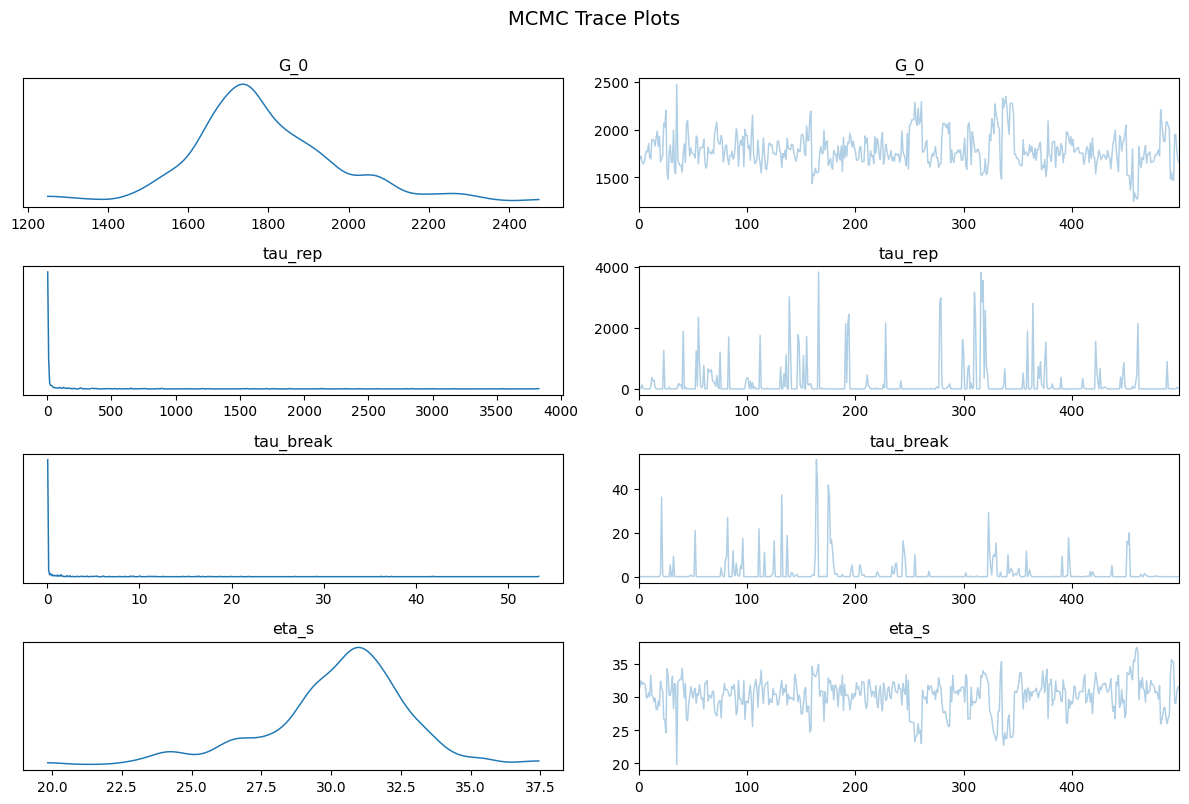

In [9]:
idata = az.from_dict(posterior={k: v.reshape(NUM_CHAINS, NUM_SAMPLES) for k, v in posterior.items()})

axes = az.plot_trace(idata, var_names=param_names, compact=False, figsize=(12, 8))
plt.suptitle('MCMC Trace Plots', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()
plt.close('all')

## ArviZ Pair Plot

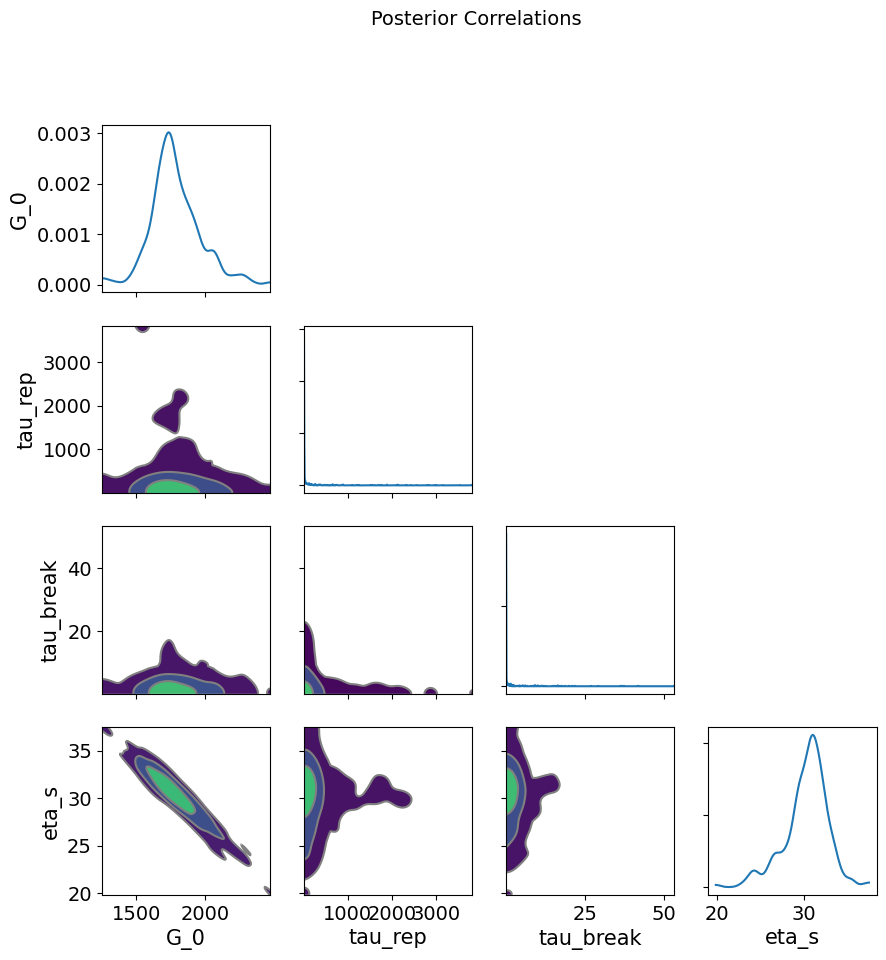

In [10]:
axes = az.plot_pair(
    idata,
    var_names=param_names,
    kind='kde',
    marginals=True,
    figsize=(10, 10)
)
plt.suptitle('Posterior Correlations', fontsize=14, y=0.995)
plt.show()
plt.close('all')

## ArviZ Forest Plot

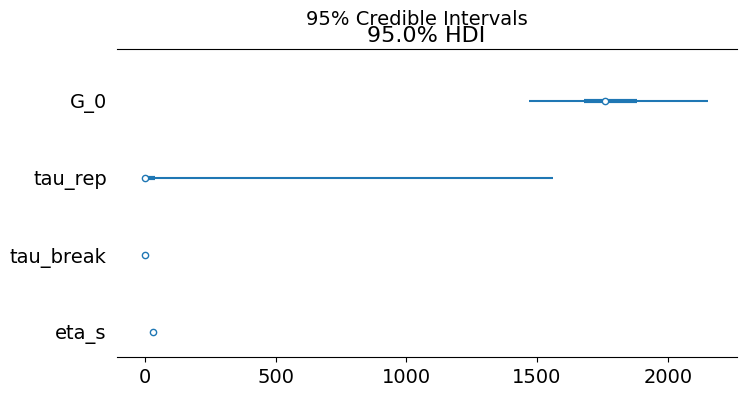

In [11]:
axes = az.plot_forest(
    idata,
    var_names=param_names,
    combined=True,
    hdi_prob=0.95,
    figsize=(8, 4)
)
plt.suptitle('95% Credible Intervals', fontsize=14)
plt.show()
plt.close('all')

## Posterior Predictive Distribution

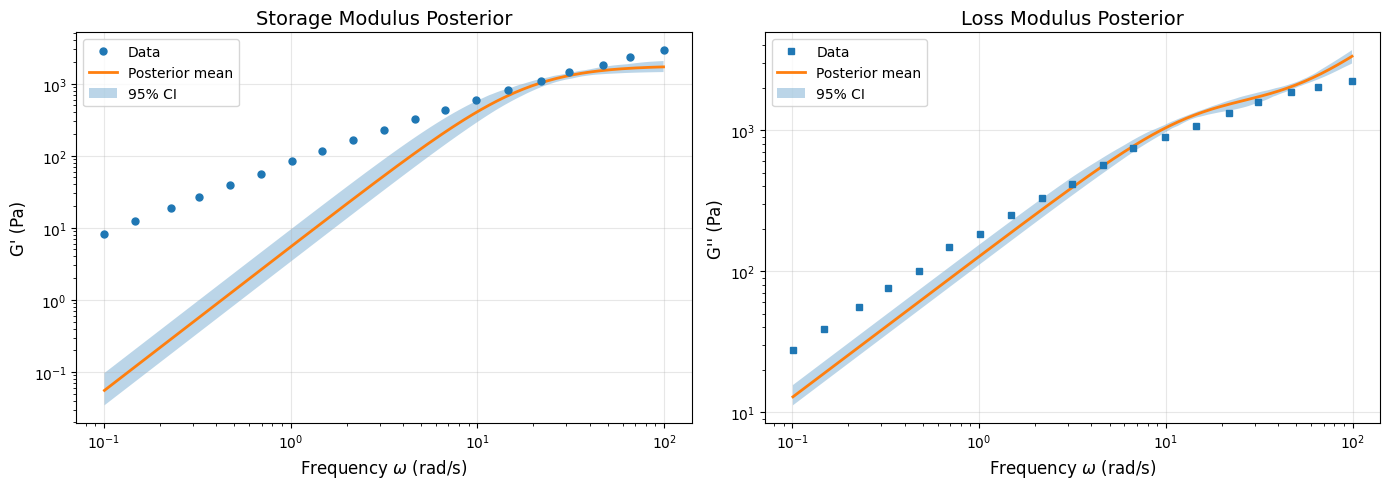

In [12]:
n_posterior_samples = 200
sample_indices = np.random.choice(NUM_SAMPLES * NUM_CHAINS, n_posterior_samples, replace=False)

predictions_Gp = []
predictions_Gpp = []
for idx in sample_indices:
    # Set model parameters from posterior sample
    for j, name in enumerate(param_names):
        model.parameters.set_value(name, float(posterior[name].flatten()[idx]))
    # Predict with updated parameters
    Gp_i, Gpp_i = model.predict_saos(omega_pred)
    predictions_Gp.append(np.array(Gp_i))
    predictions_Gpp.append(np.array(Gpp_i))

predictions_Gp = np.array(predictions_Gp)
predictions_Gpp = np.array(predictions_Gpp)
pred_mean_Gp = np.mean(predictions_Gp, axis=0)
pred_mean_Gpp = np.mean(predictions_Gpp, axis=0)
pred_lower_Gp = np.percentile(predictions_Gp, 2.5, axis=0)
pred_upper_Gp = np.percentile(predictions_Gp, 97.5, axis=0)
pred_lower_Gpp = np.percentile(predictions_Gpp, 2.5, axis=0)
pred_upper_Gpp = np.percentile(predictions_Gpp, 97.5, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.loglog(omega, G_prime_data, 'o', label='Data', markersize=5, zorder=3)
ax1.loglog(omega_pred, pred_mean_Gp, '-', linewidth=2, label='Posterior mean', zorder=2)
ax1.fill_between(omega_pred, pred_lower_Gp, pred_upper_Gp, alpha=0.3, label='95% CI', zorder=1)
ax1.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=12)
ax1.set_ylabel("G' (Pa)", fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title('Storage Modulus Posterior', fontsize=14)

ax2.loglog(omega, G_double_prime_data, 's', label='Data', markersize=5, zorder=3)
ax2.loglog(omega_pred, pred_mean_Gpp, '-', linewidth=2, label='Posterior mean', zorder=2)
ax2.fill_between(omega_pred, pred_lower_Gpp, pred_upper_Gpp, alpha=0.3, label='95% CI', zorder=1)
ax2.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=12)
ax2.set_ylabel("G'' (Pa)", fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_title('Loss Modulus Posterior', fontsize=14)

plt.tight_layout()
plt.show()
plt.close('all')

## Physical Interpretation from Posterior


Physical quantities from posterior:
  tau_d: 5.4657e-02 ± 9.2247e-03 s
  Crossover frequency (ω_c): 1.8808e+01 ± 3.1552e+00 rad/s
  zeta (tau_break/tau_rep): 9828.0543 ± 47039.3202


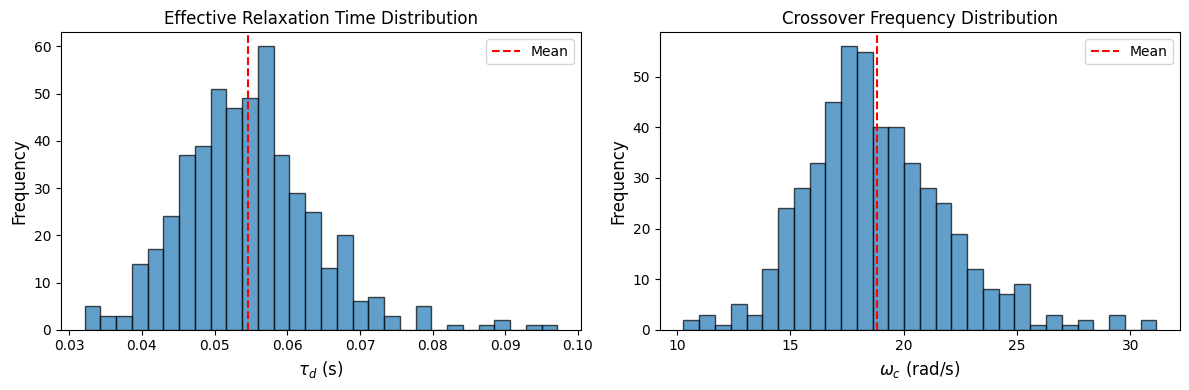

In [13]:
tau_d_posterior = np.sqrt(posterior['tau_rep'] * posterior['tau_break'])
zeta_posterior = posterior['tau_break'] / posterior['tau_rep']
omega_c_posterior = 1.0 / tau_d_posterior

print(f"\nPhysical quantities from posterior:")
print(f"  tau_d: {np.mean(tau_d_posterior):.4e} ± {np.std(tau_d_posterior):.4e} s")
print(f"  Crossover frequency (ω_c): {np.mean(omega_c_posterior):.4e} ± {np.std(omega_c_posterior):.4e} rad/s")
print(f"  zeta (tau_break/tau_rep): {np.mean(zeta_posterior):.4f} ± {np.std(zeta_posterior):.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(tau_d_posterior, bins=30, alpha=0.7, edgecolor='black')
ax1.axvline(np.mean(tau_d_posterior), color='r', linestyle='--', label='Mean')
ax1.set_xlabel(r'$\tau_d$ (s)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend()
ax1.set_title('Effective Relaxation Time Distribution', fontsize=12)

ax2.hist(omega_c_posterior, bins=30, alpha=0.7, edgecolor='black')
ax2.axvline(np.mean(omega_c_posterior), color='r', linestyle='--', label='Mean')
ax2.set_xlabel(r'$\omega_c$ (rad/s)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.legend()
ax2.set_title('Crossover Frequency Distribution', fontsize=12)

plt.tight_layout()
plt.show()
plt.close('all')

## Save Results

In [14]:
save_tnt_results(model, bayesian_result, "cates", "saos", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/tnt/../utils/../outputs/tnt/cates/saos/
  nlsq_params_saos.json: 4 parameters
  posterior_saos.json: 500 draws


## Key Takeaways

1. **Maxwell-like SAOS response** in fast-breaking limit with effective relaxation time $\tau_d$
2. **Cole-Cole semicircle** diagnostic confirms single-mode Maxwell behavior for living polymers
3. **Crossover frequency** $\omega_c = 1/\tau_d$ provides direct measurement of terminal relaxation
4. **Physical equivalence** with single-mode Maxwell at $\tau = \tau_d$ validates fast-breaking limit
5. **Bayesian inference** quantifies uncertainty in time scales from frequency response

**Next steps:** Compare $\tau_d$ across all protocols (flow, startup, relaxation, creep, SAOS) to verify global consistency.